<a href="https://colab.research.google.com/github/chasslayy/Melanin-Match-AI/blob/main/Melanin_Match_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Melanin Match AI
**Machine Learning Final Project — Mercy University (CISC 550)**  
**Student:** Chastity Lewis  
**Semester:** Fall 2025  

### Objective
Build a supervised learning model that predicts foundation shades for diverse skin tones using image data and classification models (SVM, kNN, and a CNN-based deep learning model).


In [49]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [51]:
data_path = "/content/drive/MyDrive/MelaninMatchAI/images"


In [52]:
from sklearn.model_selection import train_test_split


## 1. Setup & Imports

In [53]:
# Core Libraries
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize

# Models
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Deep Learning
import tensorflow as tf
from tensorflow.keras import layers, models

# Misc
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully.")

Libraries imported successfully.


## 2. Data Loading

In this section, you will connect to your dataset.  
You can either:

- Mount Google Drive and point to a folder of images organized by skin tone labels, or  
- Clone your GitHub repo that contains the dataset.

Update the `data_path` variable below to match your dataset location.


In [54]:
# If using Google Drive, uncomment and run this:

from google.colab import drive
drive.mount('/content/drive')

# TODO: Update this path to your actual dataset
# Example structure:
# data_path/light, data_path/tan, data_path/medium, data_path/deep, data_path/dark

# Original path: data_path = "/content/drive/MyDrive/MelaninMatchAI/data/images"
# Assuming the images are directly under an 'images' folder in the unzipped directory
data_path = "/content/MelaninMatchAI_Dataset/MelaninMatchAI/images"  # CORRECTED PATH

categories = ['light', 'tan', 'medium', 'deep', 'dark']

print("Data path set to:", data_path)
print("Categories:", categories)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Data path set to: /content/MelaninMatchAI_Dataset/MelaninMatchAI/images
Categories: ['light', 'tan', 'medium', 'deep', 'dark']


### 2.1 Preview a Sample Image

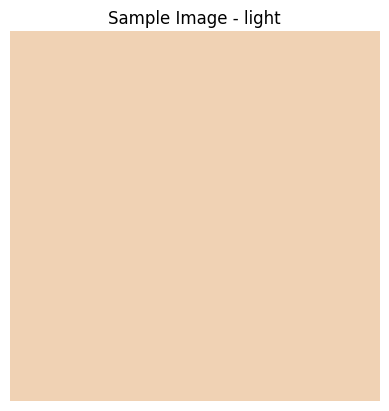

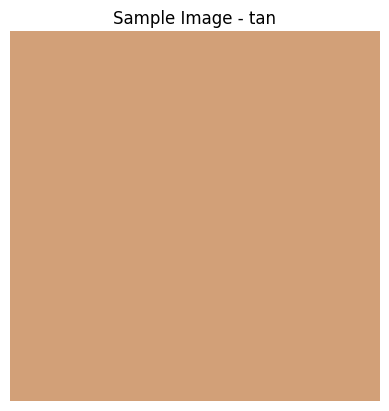

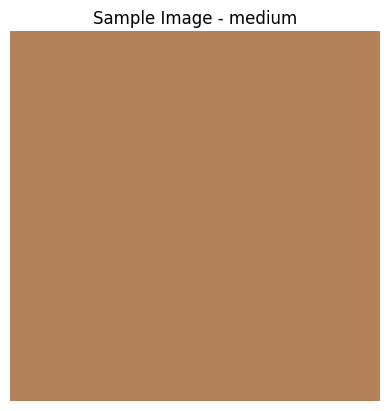

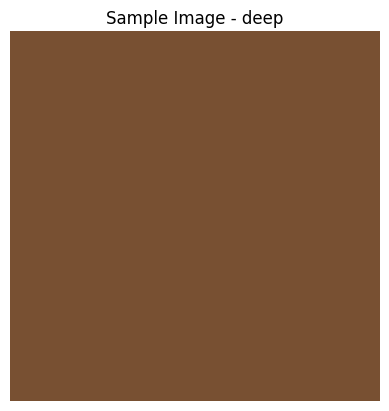

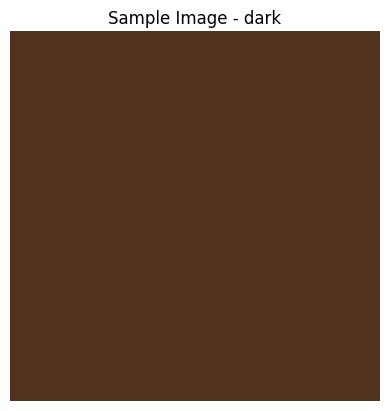

In [55]:
# This will try to preview one sample image from each category (if available)
for label in categories:
    folder = os.path.join(data_path, label)
    if not os.path.isdir(folder):
        print(f"Folder not found for category '{label}':", folder)
        continue

    files = os.listdir(folder)
    if len(files) == 0:
        print(f"No images found in folder for '{label}'")
        continue

    img_path = os.path.join(folder, files[0])
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.imshow(img_rgb)
    plt.title(f"Sample Image - {label}")
    plt.axis('off')
    plt.show()

## 3. Preprocessing

In [56]:
IMG_SIZE = (128, 128)
X, y = [], []

for label in categories:
    folder = os.path.join(data_path, label)
    if not os.path.isdir(folder):
        print(f"[WARNING] Skipping missing folder for category '{label}':", folder)
        continue

    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        try:
            img = cv2.imread(img_path)
            if img is None:
                print(f"[WARNING] Could not read image: {img_path}")
                continue

            img = cv2.resize(img, IMG_SIZE)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            X.append(img)
            y.append(label)

        except Exception as e:
            print(f"[ERROR] Failed on {img_path}: {e}")

# Convert to NumPy + normalize
X = np.array(X, dtype="float32") / 255.0
y = np.array(y)

print("Dataset size:", X.shape, y.shape)

# --- Encode labels ---
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print("Encoded classes:", le.classes_)

# --- Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded,   # keeps class balance
)

print("Train set:", X_train.shape, "Test set:", X_test.shape)


Dataset size: (50, 128, 128, 3) (50,)
Encoded classes: ['dark' 'deep' 'light' 'medium' 'tan']
Train set: (40, 128, 128, 3) Test set: (10, 128, 128, 3)


In [57]:
import zipfile
import os

zip_path = '/content/MelaninMatchAI_Dataset.zip'
extraction_path = '/content/MelaninMatchAI_Dataset'

# Create the extraction directory if it doesn't exist
os.makedirs(extraction_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

print(f"Dataset unzipped to: {extraction_path}")

Dataset unzipped to: /content/MelaninMatchAI_Dataset


After unzipping, we need to update the `data_path` to point to the correct location of the images within the extracted folder. Based on common dataset structures, the images are likely in a subfolder like `images` or `data/images` within the extracted directory.

## 4. Baseline Model — SVM

In [58]:
# Flatten images for classical machine learning models
X_train_flat = X_train.reshape(len(X_train), -1)
X_test_flat = X_test.reshape(len(X_test), -1)

# Binarize labels for multi-class AUC
classes = np.arange(len(le.classes_))
y_test_bin = label_binarize(y_test, classes=classes)

svm_model = SVC(kernel='linear', C=1, probability=True)
svm_model.fit(X_train_flat, y_train)

y_pred_svm = svm_model.predict(X_test_flat)
y_proba_svm = svm_model.predict_proba(X_test_flat)

print("=== SVM Classification Report ===")
print(classification_report(y_test, y_pred_svm, target_names=le.classes_))

print("=== SVM Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred_svm))

svm_auc = roc_auc_score(y_test_bin, y_proba_svm, multi_class='ovr')
print("SVM AUC (OvR):", svm_auc)


=== SVM Classification Report ===
              precision    recall  f1-score   support

        dark       1.00      1.00      1.00         2
        deep       1.00      1.00      1.00         2
       light       1.00      1.00      1.00         2
      medium       1.00      1.00      1.00         2
         tan       1.00      1.00      1.00         2

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10

=== SVM Confusion Matrix ===
[[2 0 0 0 0]
 [0 2 0 0 0]
 [0 0 2 0 0]
 [0 0 0 2 0]
 [0 0 0 0 2]]
SVM AUC (OvR): 1.0


In [59]:
import os

# List contents of the extracted directory
print("Contents of /content/MelaninMatchAI_Dataset:")
for root, dirs, files in os.walk('/content/MelaninMatchAI_Dataset'):
    level = root.replace('/content/MelaninMatchAI_Dataset', '').count(os.sep)
    indent = ' ' * 4 * (level)
    print(f'{indent}{os.path.basename(root)}/')
    subindent = ' ' * 4 * (level + 1)
    for d in dirs:
        print(f'{subindent}{d}/')
    if level == 0: # Only show files in the top level of the extracted folder, not deeply nested
        for f in files:
            print(f'{subindent}{f}')
    break # Only list the top level and its immediate subdirectories for brevity

Contents of /content/MelaninMatchAI_Dataset:
MelaninMatchAI_Dataset/
    MelaninMatchAI/


## 5. Baseline Model — kNN

In [60]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_flat, y_train)

y_pred_knn = knn_model.predict(X_test_flat)

print("=== kNN Classification Report ===")
print(classification_report(y_test, y_pred_knn, target_names=le.classes_))

print("=== kNN Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred_knn))

=== kNN Classification Report ===
              precision    recall  f1-score   support

        dark       1.00      1.00      1.00         2
        deep       1.00      1.00      1.00         2
       light       1.00      1.00      1.00         2
      medium       1.00      1.00      1.00         2
         tan       1.00      1.00      1.00         2

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10

=== kNN Confusion Matrix ===
[[2 0 0 0 0]
 [0 2 0 0 0]
 [0 0 2 0 0]
 [0 0 0 2 0]
 [0 0 0 0 2]]


## 6. Deep Learning Model — CNN

In [61]:
cnn_model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(categories), activation='softmax')
])

cnn_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,285 (12.61 MB)

 Trainable params: 3,305,285 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

### 6.1 Training the CNN

In [62]:
EPOCHS = 10  # You can increase this for better performance

history = cnn_model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    validation_data=(X_test, y_test)
)

Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 668ms/step - accuracy: 0.2229 - loss: 1.6269 - val_accuracy: 0.2000 - val_loss: 1.5983
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 411ms/step - accuracy: 0.2167 - loss: 1.5518 - val_accuracy: 0.4000 - val_loss: 1.5526
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 398ms/step - accuracy: 0.3479 - loss: 1.5591 - val_accuracy: 0.2000 - val_loss: 1.4536
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 422ms/step - accuracy: 0.2062 - loss: 1.4515 - val_accuracy: 0.2000 - val_loss: 1.3938
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.2125 - loss: 1.3907 - val_accuracy: 0.6000 - val_loss: 1.2603
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.6188 - loss: 1.2528 - val_accuracy: 0.8000 - val_loss: 1.1094
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 676ms/step - accuracy: 0.7438 - loss: 1.1101 - val_accuracy: 0.6000 - val_loss: 0.9783
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 902ms/step - accuracy: 0.6312 - loss: 0.9749 - val_accuracy: 0.8000 - val_loss: 0.807

### 6.2 Training & Validation Curves

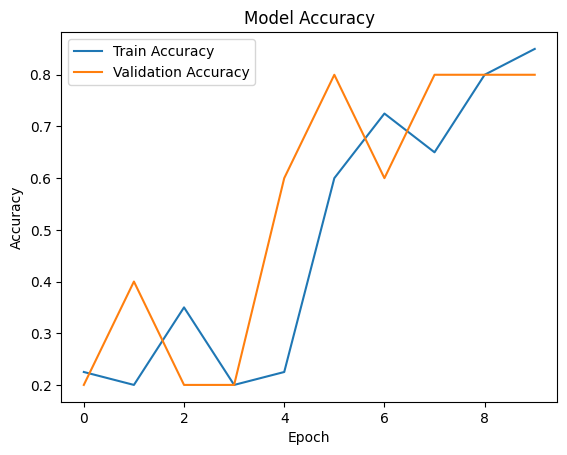

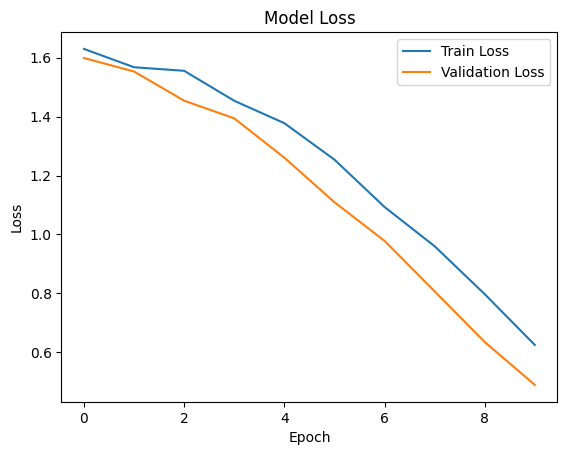

In [63]:
plt.figure()
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 6.3 CNN Evaluation

In [64]:
y_pred_cnn_probs = cnn_model.predict(X_test)
y_pred_cnn = np.argmax(y_pred_cnn_probs, axis=1)

print("=== CNN Classification Report ===")
print(classification_report(y_test, y_pred_cnn, target_names=le.classes_))

print("=== CNN Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred_cnn))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
=== CNN Classification Report ===
              precision    recall  f1-score   support

        dark       0.00      0.00      0.00         2
        deep       0.50      1.00      0.67         2
       light       1.00      1.00      1.00         2
      medium       1.00      1.00      1.00         2
         tan       1.00      1.00      1.00         2

    accuracy                           0.80        10
   macro avg       0.70      0.80      0.73        10
weighted avg       0.70      0.80      0.73        10

=== CNN Confusion Matrix ===
[[0 2 0 0 0]
 [0 2 0 0 0]
 [0 0 2 0 0]
 [0 0 0 2 0]
 [0 0 0 0 2]]


## 7. Save Model

In [65]:
model_path = "melanin_match_ai_cnn.h5"
cnn_model.save(model_path)
print(f"Model saved to {model_path}")

Model saved to melanin_match_ai_cnn.h5


## 8. Results & Discussion

- Compare the performance of **SVM**, **kNN**, and the **CNN model** using accuracy and the classification reports.
- Discuss which model performs best overall and which classes (skin tone categories) are hardest to classify.
- Reflect on any class imbalance or misclassification patterns you observe in the confusion matrices.
- You can copy key numbers and insights from this notebook into your final project report.


## 9. Conclusion & Future Work

Summarize:

- The goal of Melanin Match AI and what you achieved.
- Which model is currently your best-performing model.
- How this project supports fairness and inclusivity in shade matching.

Future work ideas:

- Use **transfer learning** with models like EfficientNet or ResNet for better performance.
- Add **data augmentation** (brightness, contrast, rotations) to make the model more robust to lighting changes.
- Collect more images for underrepresented skin tone categories to reduce bias.
- Deploy the model through a simple web app so users can upload a photo and receive shade recommendations.


### 3.1 Class Distribution

This cell plots how many images there are in each skin-tone category. Include this in your report under **Data Acquisition & Understanding**.


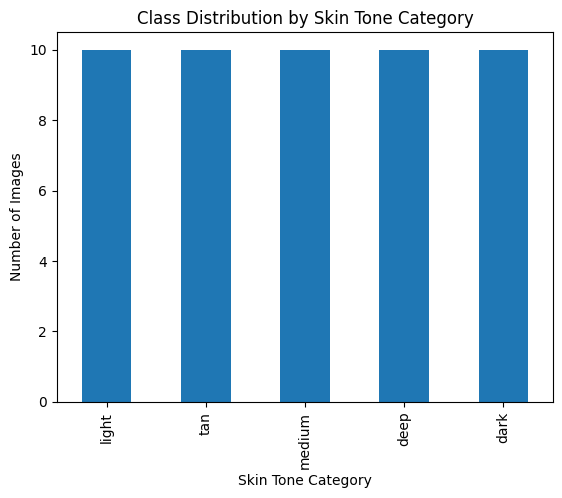

light     10
tan       10
medium    10
deep      10
dark      10
Name: count, dtype: int64


In [66]:
# Class distribution plot
label_series = pd.Series(y)
label_counts = label_series.value_counts()

plt.figure()
label_counts.plot(kind='bar')
plt.title("Class Distribution by Skin Tone Category")
plt.xlabel("Skin Tone Category")
plt.ylabel("Number of Images")
plt.show()

print(label_counts)


In [67]:
# kNN Baseline Model with AUC
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_flat, y_train)

y_pred_knn = knn_model.predict(X_test_flat)
y_proba_knn = knn_model.predict_proba(X_test_flat)

print("=== kNN Classification Report ===")
print(classification_report(y_test, y_pred_knn, target_names=le.classes_))

print("=== kNN Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred_knn))

knn_auc = roc_auc_score(y_test_bin, y_proba_knn, multi_class='ovr')
print("kNN AUC (OvR):", knn_auc)


=== kNN Classification Report ===
              precision    recall  f1-score   support

        dark       1.00      1.00      1.00         2
        deep       1.00      1.00      1.00         2
       light       1.00      1.00      1.00         2
      medium       1.00      1.00      1.00         2
         tan       1.00      1.00      1.00         2

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10

=== kNN Confusion Matrix ===
[[2 0 0 0 0]
 [0 2 0 0 0]
 [0 0 2 0 0]
 [0 0 0 2 0]
 [0 0 0 0 2]]
kNN AUC (OvR): 1.0


In [68]:
# CNN AUC and Model Comparison Table
# CNN probabilities & predictions are already computed in y_pred_cnn_probs, y_pred_cnn

# Binarize labels for CNN AUC if not already done
try:
    y_test_bin
except NameError:
    classes = np.arange(len(le.classes_))
    y_test_bin = label_binarize(y_test, classes=classes)

cnn_auc = roc_auc_score(y_test_bin, y_pred_cnn_probs, multi_class='ovr')
print("CNN AUC (OvR):", cnn_auc)

results = []

# SVM metrics
results.append({
    "Model": "SVM",
    "Accuracy": accuracy_score(y_test, y_pred_svm),
    "F1_macro": f1_score(y_test, y_pred_svm, average='macro'),
    "AUC_ovr": svm_auc
})

# kNN metrics
results.append({
    "Model": "kNN",
    "Accuracy": accuracy_score(y_test, y_pred_knn),
    "F1_macro": f1_score(y_test, y_pred_knn, average='macro'),
    "AUC_ovr": knn_auc
})

# CNN metrics
results.append({
    "Model": "CNN",
    "Accuracy": accuracy_score(y_test, y_pred_cnn),
    "F1_macro": f1_score(y_test, y_pred_cnn, average='macro'),
    "AUC_ovr": cnn_auc
})

results_df = pd.DataFrame(results)
print("\n=== Model Comparison ===")
print(results_df)


CNN AUC (OvR): 1.0

=== Model Comparison ===
  Model  Accuracy  F1_macro  AUC_ovr
0   SVM       1.0  1.000000      1.0
1   kNN       1.0  1.000000      1.0
2   CNN       0.8  0.733333      1.0
